### Data Loading and Label Mapping

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification,pipeline
from googlesearch import search
from bs4 import BeautifulSoup
import requests
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from scraping_selenium import people_also_ask
import re
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import pandas as pd

c:\Users\hetan\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\hetan\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


c:\Users\hetan\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
df = pd.read_csv('Test_dataset(FINAL).csv')
df

,Headline,Source,Question_phi,Question_Mistral,Label
0,NASA’s Perseverance rover finds its first poss...,sciencenews.org,"""Has NASA's Perseverance rover discovered evid...","""Has NASA officially announced the discovery o...",True
1,Sepsis tests take days putting patients at ri...,sciencenews.org,"""What is the current average wait time for sep...","""Is there a recent study or research that show...",True
2,Nasa's DART asteroid unlocks complex history o...,https://timesofindia.indiatimes.com/,"""What is the history of NASA's DART mission an...","""Has NASA's DART mission provided evidence of ...",True
3,Say goodbye to back pain patients go for adva...,https://timesofindia.indiatimes.com/,"""What are the benefits of advanced endoscopy s...","""Has 'advanced endoscopy spine surgery for sci...",True
4,Neurodivergent children more likely to develop...,https://timesofindia.indiatimes.com/,"""What does the study find about the likelihood...","""Is there a peer-reviewed study titled 'Neurod...",True
...,...,...,...,...,...
683,"""Google's parent company faces UK investigatio...",Synthetically Generated,"""Has Google's parent company been investigated...","""Has Alphabet Inc., Google's parent company, b...",False
684,"""Intel announces hiring spree to fund recovery...",Synthetically Generated,"""What is the current hiring status of Intel as...","""Has Intel announced a hiring spree to fund re...",False
685,"""Ola Electric IPO grey market premium skyrocke...",Synthetically Generated,"""What is the current grey market premium for O...","""Has the Ola Electric IPO grey market premium ...",False
686,"""Japan's Nikkei 225 Index Soars 12.4%, Its Big...",Synthetically Generated,"""What was the percentage increase in Japan's N...","1. ""Is there a news article from a reliable so...",False


In [3]:
# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Headline,Source,Question_phi,Question_Mistral,Label
0,King calls for better live performance venues ...,https://www.hindustantimes.com,"""What initiatives has King proposed to improve...","""Has [King's name] recently made a public stat...",True
1,"India Finish Fourth Again, Miss Out On Olympic...",https://sports.ndtv.com/,"""Did India's mixed team skeet shooting team wi...","""Has India finished fourth in the Olympics Sho...",True
2,Alpine Turn To Briton Oliver Oakes As New F1 T...,https://sports.ndtv.com/,"""Who is the new F1 team principal announced by...","""Has Oliver Oakes been officially announced as...",True
3,Global crypto market sees massive drop in mark...,https://www.businesstoday.in/,"""What was the market capitalization of the glo...","""Has the global crypto market experienced a si...",True
4,"""Elon Musk disrupts Netanyahu's speech to Cong...",Synthetically Generated,"""Did Elon Musk interrupt Netanyahu's speech to...","""Did Elon Musk attend Netanyahu's speech to Co...",False


In [4]:
df['Label'].value_counts()

Label
True     344
False    344
Name: count, dtype: int64

<Axes: ylabel='Label'>

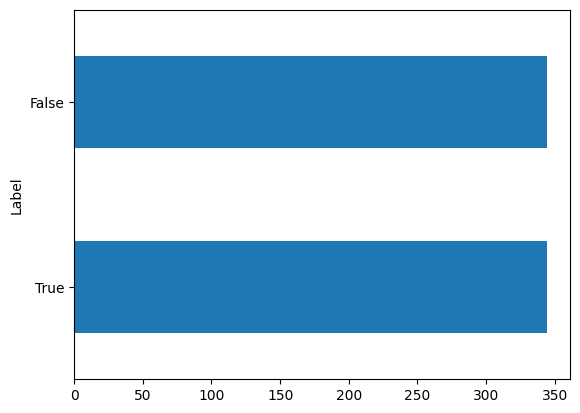

In [5]:
df['Label'].value_counts().plot(kind='barh')

Article Pipeline Utility

In [6]:

def get_top_links(query, num_links=1):
    linksgot = []
    try:
        # Perform Google search and get the top links
        search_results = search(query, num_results=num_links)

        # Print the top links
        for i, link in enumerate(search_results, start=1):
            linksgot.append(link)
    except Exception as e:
        print(f"An error occurred: {e}")
    return linksgot


def get_title_and_content(search_query_results):
    article_titles = []
    article_content = []

    # Set up Selenium options (headless mode if needed)
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    chrome_options.add_argument('log-level=1')

    cService = Service(executable_path='../chromedriver-win64/chromedriver.exe')
    driver = webdriver.Chrome(service=cService,options=chrome_options)

    if search_query_results:
        for result in search_query_results:
            try:
                # Navigate to the URL
                driver.get(result)

                # Scrape <h1> tags for titles
                h1_tags = driver.find_elements(By.TAG_NAME, 'h1')
                currenth1 = " ".join([h1.text for h1 in h1_tags])
                article_titles.append(currenth1)

                # Scrape <p> tags for content
                p_tags = driver.find_elements(By.TAG_NAME, 'p')
                currentp = " ".join([p.text for p in p_tags])
                article_content.append(currentp)

            except Exception as e:
                print(f"An error occurred: {e}")

    # Quit the driver'
    driver.close()
    driver.quit()

    return article_titles, article_content

# Get the titles and contents
def make_data(search_query_results):
    titles, contents = get_title_and_content(
        get_top_links(search_query_results))

    # Create a pandas DataFrame
    data = {'Title': titles, 'Content': contents}
    df = pd.DataFrame(data)
    return df

### LLM Pipeline

In [7]:
#Load FactCC Model pipeline
pipe = pipeline(model="manueldeprada/FactCC", task="text-classification", max_length=512)

c:\Users\hetan\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [8]:
#To answer the question generated by LLM via google
def google_search(query):
    headers = {
        'User-agent':
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.67 Safari/537.36'
    }
    
    # Perform the Google search
    search_url = f'https://www.google.com/search?q={query}'
    html = requests.get(search_url, headers=headers)
    
    # Parse the HTML response
    soup = BeautifulSoup(html.text, 'html.parser')
    
    #extract answer from summary answer on google
    if soup.select_one('.hgKElc'):
        answer = soup.select_one('.hgKElc').text 

    # Extract the answer (assuming it's in a specific class) -> QUICK ANSWER BOX
    elif soup.select_one('.DI6Ufb'):
        answer = soup.select_one('.DI6Ufb')
        answer = answer.find(class_='Z0LcW t2b5Cf').text
        answer=query+' '+answer
    
    elif not soup.select_one('.DI6Ufb'):
        result=people_also_ask(search_url)
        # print("Result of the Scraping",result)
        if len(result)==2:
            answer=f'{result[0]} {result[1]}'
        else:
            #incase people also asked also comes empty we revert to the article pipeline
            scraped_df = make_data(query)
            scraped_df.dropna(inplace=True)

            # Convert the 'Content' column to strings
            scraped_df['Content'] = scraped_df['Content'].astype(str)

            # Sort the DataFrame based on the length of the strings in the 'Content' column
            scraped_df = scraped_df.sort_values(by='Content', key=lambda x: x.str.len(), ascending=False)

            if len(scraped_df) == 0 or not scraped_df['Content'][0] or '403 Forbidden' in scraped_df['Content'][0] or '403 Forbidden' in scraped_df['Title'][0] :
                #Could not retrieve articles related to headline, Could possibly be a false claim OR Scraper got blocked/forbidden
                return str('Cannot retrieve articles, most likely to be false')

            scraped_content = (
            f"{scraped_df['Title'][0]} \n{scraped_df['Content'][0]}")
            answer = scraped_content
    return answer

In [9]:
def FactCC_Mistral(input_headline ,Mistral_generated_question):
    quickSearchAnswer = google_search(Mistral_generated_question)

    #compare scraped info as source and headline as the claim
    ans = pipe([[[quickSearchAnswer,Mistral_generated_question]]], truncation=True, padding='max_length')

    # print('Input headline : ', input_headline)
    # print('Mistral Generated Question : ', Mistral_generated_question)
    # print('Scraped Answer : ', quickSearchAnswer)
    if ans[0]['label'] == 'CORRECT':
        return True,quickSearchAnswer
    else:
        return False,quickSearchAnswer

In [10]:
model_decision, scraped_content = FactCC_Mistral(df['Headline'][0],df['Question_Mistral'][0])
actual_decision = df['Label'][0]
print(model_decision,actual_decision)
if (model_decision) == (actual_decision):
    print('Correct Decision')
else:
    print('Incorrect Decision')

People Also Asked questions dont exist for this category
An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3D%2522Has%252B%255BKing%2527s%252Bname%255D%252Brecently%252Bmade%252Ba%252Bpublic%252Bstatement%252Badvocating%252Bfor%252Bbetter%252Blive%252Bperformance%252Bvenues%252Bto%252Bsupport%252Bemerging%252Bartistes%253F%2522%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGI_x7bUGIjCwUlBcsDbV9ntzxB5XrI0jmkRbi8W2rhHxcSdd1HeHqJB-gkfokOTVEFJYGrOnPg0yAXJaAUM
False True
Incorrect Decision


In [11]:
df.head() #For testing

,Headline,Source,Question_phi,Question_Mistral,Label
0,King calls for better live performance venues ...,https://www.hindustantimes.com,"""What initiatives has King proposed to improve...","""Has [King's name] recently made a public stat...",True
1,"India Finish Fourth Again, Miss Out On Olympic...",https://sports.ndtv.com/,"""Did India's mixed team skeet shooting team wi...","""Has India finished fourth in the Olympics Sho...",True
2,Alpine Turn To Briton Oliver Oakes As New F1 T...,https://sports.ndtv.com/,"""Who is the new F1 team principal announced by...","""Has Oliver Oakes been officially announced as...",True
3,Global crypto market sees massive drop in mark...,https://www.businesstoday.in/,"""What was the market capitalization of the glo...","""Has the global crypto market experienced a si...",True
4,"""Elon Musk disrupts Netanyahu's speech to Cong...",Synthetically Generated,"""Did Elon Musk interrupt Netanyahu's speech to...","""Did Elon Musk attend Netanyahu's speech to Co...",False


In [12]:
import csv
import os
from tqdm import tqdm
predictions = []
actuals = []
results = []
batch_size = 2
csv_filename = 'Pipeline_LLM(Mistral).csv'
processed_headlines = set()

# Check if CSV file already exists and load processed headlines
if os.path.exists(csv_filename):
    with open(csv_filename, 'r', newline='', encoding='utf-8') as csvfile:
        csvreader = csv.reader(csvfile, delimiter='|')
        next(csvreader)  # Skip header
        for row in csvreader:
            if len(row) < 2:  # Skip rows that may not have all columns
                continue
            headline = row[1]
            processed_headlines.add(headline)


try:
    # Open the CSV file for writing with '|' as the delimiter
    with open(csv_filename, 'a', newline='', encoding='utf-8') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter='|')
        if not processed_headlines:
            csvwriter.writerow(['Index', 'Headline','Scraped_Content','Question_Mistral', 'Model Decision', 'Actual Decision'])
        
        # Iterate over each row in the dataframe
        for index, row in tqdm(df.iterrows(),total= len(df)):
            try:
                headline = row['Headline']
                if headline in processed_headlines:
                    print(f"Skipping already processed headline: {headline}")
                    continue
                model_decision,scraped_content = FactCC_Mistral(row['Headline'], row['Question_Mistral'])
                # Convert scraped content to a single line
                scraped_content_single_line = ' '.join(scraped_content.splitlines()).strip().replace('|', ' ')
                actual_decision = row['Label']
                predictions.append(model_decision)
                actuals.append(actual_decision)
                
                # Write the results to the CSV file
                results.append([index, row['Headline'], scraped_content_single_line, row['Question_Mistral'],model_decision, actual_decision])
                
                # print(f"Index: {index}, Model Decision: {model_decision}, Actual Decision: {actual_decision}")
                # print(f"------------------------------------------------------------------------------------")
                time.sleep(5) 
                if len(results) % batch_size == 0:
                        csvwriter.writerows(results)
                        csvfile.flush()
                        os.fsync(csvfile.fileno())
                        results = [] # Delay to prevent rate limiting
            except Exception as e:
                print(f"Error processing row {index}: {str(e)}")
                continue

        # Write any remaining results
        if results:
            csvwriter.writerows(results)
            csvfile.flush()
            os.fsync(csvfile.fileno())

    # Calculate the metrics
    accuracy = accuracy_score(actuals, predictions)
    precision = precision_score(actuals, predictions, pos_label=True)
    recall = recall_score(actuals, predictions, pos_label=True)
    f1 = f1_score(actuals, predictions, pos_label=True)

    # Append the metrics to the CSV file
    with open(csv_filename, 'a', newline='', encoding='utf-8') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter='|')
        csvwriter.writerow([])  # Add an empty row for separation
        csvwriter.writerow(['Metric', 'Value'])
        csvwriter.writerow(['Accuracy', accuracy])
        csvwriter.writerow(['Precision', precision])
        csvwriter.writerow(['Recall', recall])
        csvwriter.writerow(['F1 Score', f1])

    print(f'Results written to {csv_filename}')
    print(f'Final file size: {os.path.getsize(csv_filename)} bytes')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

except Exception as e:
    print(f"An error occurred: {str(e)}")

finally:
    if os.path.exists(csv_filename):
        print(f"CSV file exists. Size: {os.path.getsize(csv_filename)} bytes")
    else:
        print("CSV file does not exist.")

Existing mistral_pipeline.csv has been deleted.


  0%|          | 0/688 [00:00<?, ?it/s]

People Also Asked questions dont exist for this category
An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3D%2522Has%252B%255BKing%2527s%252Bname%255D%252Brecently%252Bmade%252Ba%252Bpublic%252Bstatement%252Badvocating%252Bfor%252Bbetter%252Blive%252Bperformance%252Bvenues%252Bto%252Bsupport%252Bemerging%252Bartistes%253F%2522%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGKPx7bUGIjCQu-Nfrw9r5g1JJwHvSJgwkC3vf1AVr1WzA6NGQmDo7i6eDv-NbvcLnMTLONiHbkwyAXJaAUM


  0%|          | 1/688 [00:22<4:23:12, 22.99s/it]

People Also Asked questions dont exist for this category
An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3D%2522Has%252BIndia%252Bfinished%252Bfourth%252Bin%252Bthe%252BOlympics%252BShooting%252BMixed%252BTeam%252BSkeet%252Bevent%252Bin%252Bthe%252Bmost%252Brecent%252Bgames%253F%2522%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgQxzF7eGLrx7bUGIjC5ANGv8AXXRxj6gtk3S3N6VOWae_MrT0z7te1CAYIyInxQvBNTb5Q0ZPTFpySQukkyAXJaAUM


  0%|          | 2/688 [00:45<4:19:45, 22.72s/it]

People Also Asked questions dont exist for this category
An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3D%2522Has%252BOliver%252BOakes%252Bbeen%252Bofficially%252Bannounced%252Bas%252Bthe%252Bnew%252BTeam%252BPrincipal%252Bof%252BAlpine%252BF1%252BTeam%253F%2522%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGNHx7bUGIjBpSRpdJYMgIaD4S9XTz89Taj49kx6UGCDW9JOriAXI1rxmD2zXXysmgcA5kwgmevgyAXJaAUM


  0%|          | 3/688 [01:08<4:19:41, 22.75s/it]

People Also Asked questions dont exist for this category
An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3D%2522Has%252Bthe%252Bglobal%252Bcrypto%252Bmarket%252Bexperienced%252Ba%252Bsignificant%252Bdrop%252Bin%252Bmarket%252Bcap%252Bon%252Bthe%252Bdate%252Bspecified%252C%252Bcausing%252Bbitcoin%252Bto%252Bbriefly%252Bgo%252Bbelow%252B%252450%252C000%253F%2522%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgTLXD6CGOfx7bUGIjDLNY-Tj-mBfOln2s6iUabvGH5uyxqkf2aQ8IyZzkWHQ3iLRf9sFB6ITnPaaDflli4yAXJaAUM


  1%|          | 4/688 [01:34<4:29:12, 23.61s/it]


CSV file exists. Size: 1130 bytes


KeyboardInterrupt: 